### tf gpu with alibi_detect environment setup
```bash
conda create --name=tf2 python=3.9
conda activate tf2
conda install -c conda-forge cudatoolkit=11.2.2 cudnn=8.1.0
exit
conda activate tf2
python3 -c "import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'; import tensorflow as tf; print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))"
python3 -m pip install tensorflow==2.10
python3 -c "import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'; import tensorflow as tf; print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))"
conda list | grep tensorflow
python3 -m pip remove tensorflow==2.10
python3 -m pip uninstall tensorflow==2.10
mkdir -p $CONDA_PREFIX/etc/conda/activate.d
echo 'export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/' > $CONDA_PREFIX/etc/conda/activate.d/env_vars.sh
exit
conda activate tf2
python3 -m pip install tensorflow==2.10
python3 -c "import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'; import tensorflow as tf; print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))"
pip install alibi-detect
pip install alibi-detect[tensorflow]
pip install tensorflow_probability==0.12.2
```


In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

2023-05-04 16:36:46.945775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 16:36:47.059548: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-04 16:36:47.473829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/skb/miniconda3/envs/tf2/lib/python3.9/site-packages/cv2/../../lib64::/home/skb/miniconda3/envs/tf2/lib/
2023-05-04 16:36:47.475201: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not 

2.10.0


/home/skb/miniconda3/envs/tf2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# debug note
https://github.com/huggingface/transformers/issues/18549
pip uninstall tokenizers
pip install transformers

In [2]:
##########################################################################
#Load data. We only need good data and anything NOT good is an outlier. 

image_directory = './datasets/'
SIZE = 128
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

good_images = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(good_images[:900]):
    # print (image_name)
    if (image_name.split('.')[-1] == 'jpg'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
    

dataset = np.array(dataset)

train = dataset[0:10]
test = dataset[11:15]

train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

#Let us also load bad images to verify our trained model. 
bad_images = os.listdir(image_directory + 'bad')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[-1] == 'jpg'):
        image = cv2.imread(image_directory + 'bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.
train.shape

(10, 128, 128, 3)

In [3]:
#########################################################################
#Define the encoder - decoder network for input to the OutlierVAE detector class. 
#Can be any encoder and decoder. 

encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
# dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 
dense_dim = [16, 16, 512]
#Define encoder
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),                           # 128,128,3(input)
      # filters, kernel_size, strides=(1, 1), padding=    
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),  #>> 64*64*64
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu), #>> 32*32*128
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu), #>> 16*16*512
      Flatten(),                                                          #>> 16x16x512=131072
      Dense(encoding_dim,)                                                  #
  ])

print(encoder_net.summary())
print("input shape: ",encoder_net.input_shape)

#Define the decoder. 
#Start with the bottleneck dimension (encoder vector) and connect to dense layer 
#with dim = total nodes in the last conv. in the encoder. 
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

2023-05-04 16:37:23.637499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 16:37:23.649413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 16:37:23.649486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-04 16:37:23.650102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 512)       1049088   
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
Total params: 135,402,176
Trainable params: 135,402,176
Non-trainable params: 0
_________________________________________________________________
None
input shape:  (None, 128, 128, 3)


In [4]:
print(decoder_net.summary())
print("output shape",decoder_net.input_shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 131072)            134348800 
                                                                 
 reshape (Reshape)           (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      2097408   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 64)       262208    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 3)      3075      
 ranspose)                                                       
                                                      

In [5]:
#######################################################################
#Define and train the outlier detector. 

latent_dim = 1024  #(Same as encoding dim. )

# initialize outlier detector
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

print("Current threshold value is: ", od.threshold)


Current threshold value is:  0.015


In [6]:
# train
#from alibi_detect.models.tensorflow.losses import elbo #evidence lower bound loss

adam = tf.keras.optimizers.Adam(lr=1e-4)

history = od.fit(train,
                 optimizer = adam,
                 epochs=1,
                 batch_size=50,
                 verbose=True)

#Check the threshold value. Should be the same as defined before. 
print("Current threshold value is: ", od.threshold)

/home/skb/miniconda3/envs/tf2/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-05-04 16:37:25.352336: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-05-04 16:37:26.313855: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-04 16:37:26.342426: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-04 16:37:26.342485: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-05-04 16:37:26.377788: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-04 16:37:26.377898: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Fai

1/1 [=] - 3s 3s/step - loss_ma: 212191.7500
Current threshold value is:  0.015


In [7]:
#
#infer_threshold Updates threshold by a value inferred from the percentage of 
#instances considered to be outliers in a sample of the dataset.
#percentage of X considered to be normal based on the outlier score.
#Here, we set it to 99%
od.infer_threshold(test, outlier_type='instance', threshold_perc=99.0)
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.04067375179380178


2023-05-04 16:37:28.140189: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-04 16:37:28.140247: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [8]:
# save the trained outlier detector
#As mentioned in their documentation, save and load is having issues in python3.6 but works fine in 3.7
# from alibi_detect.utils import save_detector, load_detector  #If this does not work, try the next line
# # from alibi_detect.utils.saving import save_detector, load_detector #Use this if the above line does not work. 
# save_detector(od, "./saved_outlier_models/ocean-surface_od_20epochs.h5")
# od = load_detector(filepath)

The instance score is: 0.012203686
Is this image an outlier (0 for NO and 1 for YES)? 1
Current threshld value is:  0.002
['instance_score', 'feature_score', 'is_outlier']


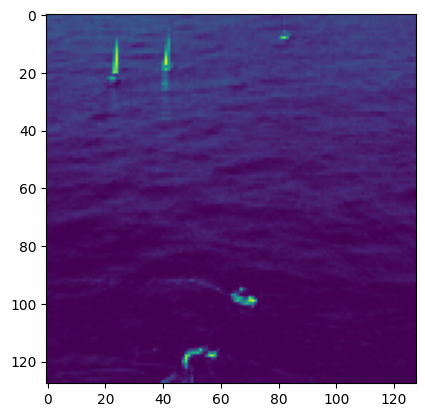

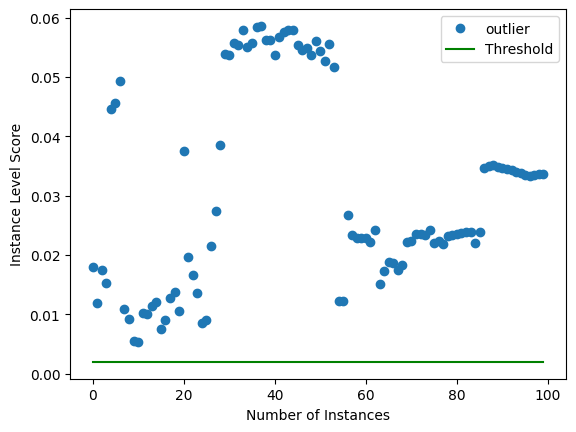

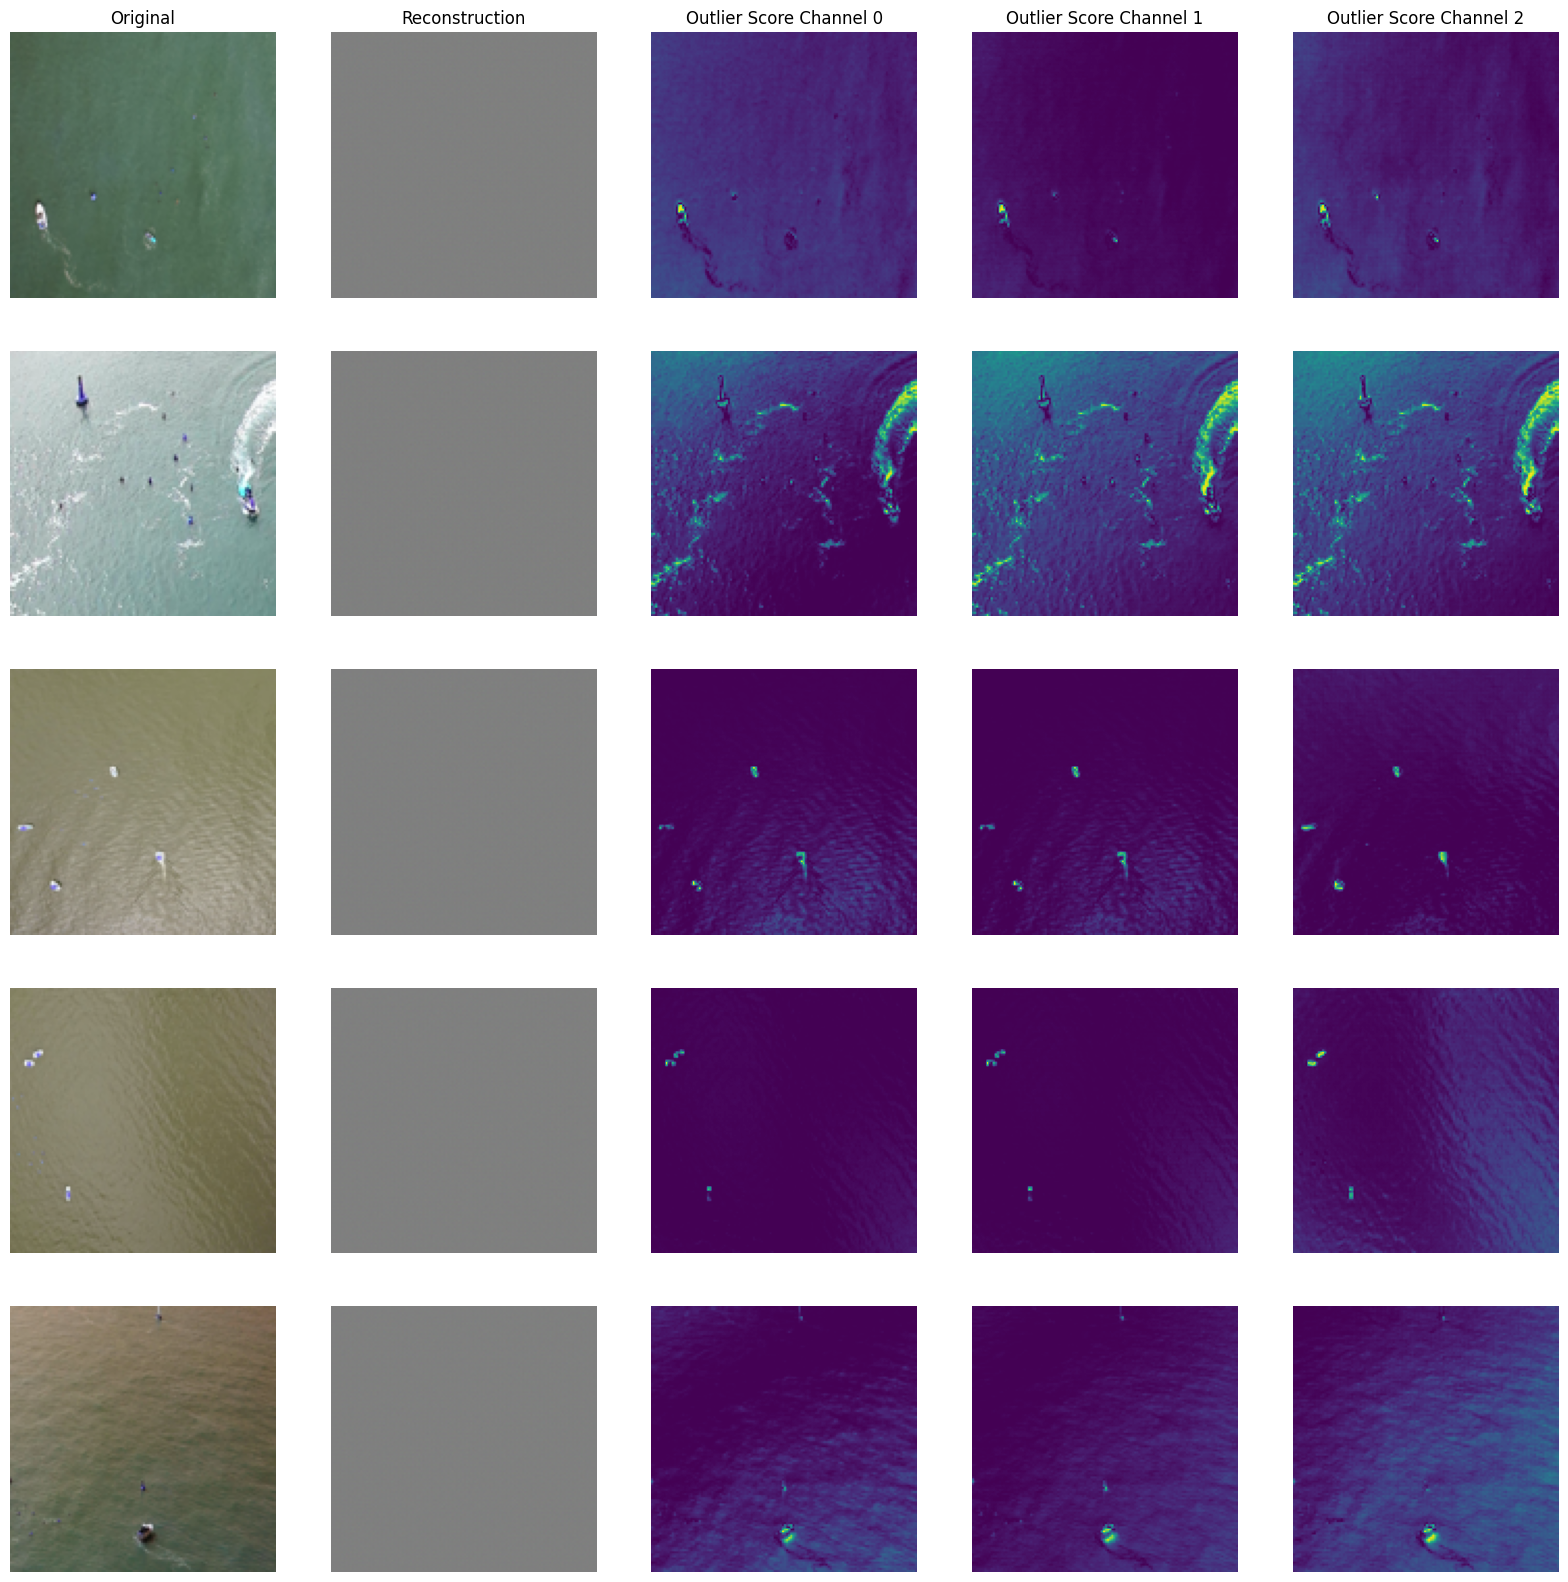

In [11]:
#Test our model on a bad image
img_num = 55
test_bad_image = bad_dataset[img_num].reshape(1, SIZE, SIZE, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])

#You can also manually define the threshold based on your specific use case. 
od.threshold = 0.002
print("Current threshld value is: ", od.threshold)

#Let us check it for multiple images
X = bad_dataset[:]

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[21, 4, 9, 15, 66],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

#######################################

